In [4]:
import os
import shutil
import random
import math
import numpy as np
import pandas as pd
import pickle
import PIL
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from keras.optimizers import Adam

Using TensorFlow backend.


### Download [CEDAR Signature dataset](http://www.cedar.buffalo.edu/NIJ/data/signatures.rar)

CEDAR signature database contains signatures of 55 signers belonging to various cultural and professional backgrounds.
Each of these signers signed 24 genuine signatures 20 minutes apart. Each of the forgers tried to emulate the signatures
of 3 persons, 8 times each, to produce 24 forged signatures for each of the genuine signers. Hence the dataset comprise
55 × 24 = 1, 320 genuine signatures as well as 1, 320 forged signatures. The signature images in this dataset are available in gray scale mode.

In [46]:
!wget http://www.cedar.buffalo.edu/NIJ/data/signatures.rar .

--2020-11-18 13:17:52--  http://www.cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving www.cedar.buffalo.edu (www.cedar.buffalo.edu)... 128.205.33.100
Connecting to www.cedar.buffalo.edu (www.cedar.buffalo.edu)|128.205.33.100|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cedar.buffalo.edu/NIJ/data/signatures.rar [following]
--2020-11-18 13:17:52--  https://cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving cedar.buffalo.edu (cedar.buffalo.edu)... 128.205.33.100
Connecting to cedar.buffalo.edu (cedar.buffalo.edu)|128.205.33.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253587033 (242M) [text/plain]
Saving to: ‘signatures.rar’

signatures.rar      100%[===================>] 241.84M  55.7MB/s    in 4.6s    

2020-11-18 13:17:57 (52.4 MB/s) - ‘signatures.rar’ saved [253587033/253587033]

--2020-11-18 13:17:57--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to reso

In [47]:
!wget https://download1.rpmfusion.org/nonfree/el/updates/7/x86_64/u/unrar-5.4.5-1.el7.x86_64.rpm

--2020-11-18 13:22:19--  https://download1.rpmfusion.org/nonfree/el/updates/7/x86_64/u/unrar-5.4.5-1.el7.x86_64.rpm
Resolving download1.rpmfusion.org (download1.rpmfusion.org)... 193.28.235.60, 2001:67c:1740:8005::60
Connecting to download1.rpmfusion.org (download1.rpmfusion.org)|193.28.235.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150648 (147K) [application/x-rpm]
Saving to: ‘unrar-5.4.5-1.el7.x86_64.rpm’

unrar-5.4.5-1.el7.x 100%[===================>] 147.12K   548KB/s    in 0.3s    

2020-11-18 13:22:20 (548 KB/s) - ‘unrar-5.4.5-1.el7.x86_64.rpm’ saved [150648/150648]



#### Install unrar utility

In [49]:
!sudo yum -y install ./unrar-5.4.5-1.el7.x86_64.rpm

Loaded plugins: dkms-build-requires, priorities, update-motd, upgrade-helper,
              : versionlock
Examining ./unrar-5.4.5-1.el7.x86_64.rpm: unrar-5.4.5-1.el7.x86_64
Marking ./unrar-5.4.5-1.el7.x86_64.rpm to be installed
Resolving Dependencies
--> Running transaction check
---> Package unrar.x86_64 0:5.4.5-1.el7 will be installed
--> Finished Dependency Resolution

Dependencies Resolved

 Package    Arch        Version            Repository                      Size
Installing:
 unrar      x86_64      5.4.5-1.el7        /unrar-5.4.5-1.el7.x86_64      303 k

Transaction Summary
Install  1 Package

Total size: 303 k
Installed size: 303 k
Running transaction check
Running transaction test
Transaction test succeeded
Running transaction
  Installing : unrar-5.4.5-1.el7.x86_64                                     1/1 
  Verifying  : unrar-5.4.5-1.el7.x86_64                                     1/1 

Installed:
  unrar.x86_64 0:5.4.5-1.el7                                                 

In [50]:
!unrar x signatures.rar ./data/


UNRAR 5.40 freeware      Copyright (c) 1993-2016 Alexander Roshal


Extracting from signatures.rar

Creating    ./data/signatures                                         OK
Creating    ./data/signatures/full_forg                               OK
Extracting  ./data/signatures/full_forg/forgeries_10_1.png               0  OK 
Extracting  ./data/signatures/full_forg/forgeries_10_10.png              0  OK 
Extracting  ./data/signatures/full_forg/forgeries_10_11.png              0  OK 
Extracting  ./data/signatures/full_forg/forgeries_10_12.png              0  OK 
Extracting  ./data/signatures/full_forg/forgeries_10_13.png              0  OK 
Extracting  ./data/signatures/full_forg/forgeries_10_14.png              0  OK 
Extracting  ./data/signatures/full_forg/forgeries_10_15.png              0  OK 
Extracting  ./data/signatures/full_forg/forgeries_10_16.png              0  OK 
Extracting  ./data/signatures/full_forg/forgeries_10_17.png              0  OK 
Extracting  ./data/signatures/ful

Extracting  ./data/signatures/full_forg/forgeries_14_6.png               3  OK 
Extracting  ./data/signatures/full_forg/forgeries_14_7.png               3  OK 
Extracting  ./data/signatures/full_forg/forgeries_14_8.png               3  OK 
Extracting  ./data/signatures/full_forg/forgeries_14_9.png               3  OK 
Extracting  ./data/signatures/full_forg/forgeries_15_1.png               3  OK 
Extracting  ./data/signatures/full_forg/forgeries_15_10.png              3  OK 
Extracting  ./data/signatures/full_forg/forgeries_15_11.png              3  OK 
Extracting  ./data/signatures/full_forg/forgeries_15_12.png              3  OK 
Extracting  ./data/signatures/full_forg/forgeries_15_13.png              3  OK 
Extracting  ./data/signatures/full_forg/forgeries_15_14.png              3  OK 
Extracting  ./data/signatures/full_forg/forgeries_15_15.png              3  OK 
Extracting  ./data/signatures/full_forg/forgeries_15_16.png              3  OK 
Extracting  ./data/signatures/full_forg/

Extracting  ./data/signatures/full_forg/forgeries_19_23.png              7%  OK 
Extracting  ./data/signatures/full_forg/forgeries_19_24.png                7%  OK 
Extracting  ./data/signatures/full_forg/forgeries_19_3.png                 7%  OK 
Extracting  ./data/signatures/full_forg/forgeries_19_4.png                 7%  OK 
Extracting  ./data/signatures/full_forg/forgeries_19_5.png                 7%  OK 
Extracting  ./data/signatures/full_forg/forgeries_19_6.png                 7%  OK 
Extracting  ./data/signatures/full_forg/forgeries_19_7.png                 7%  OK 
Extracting  ./data/signatures/full_forg/forgeries_19_8.png                 7%  OK 
Extracting  ./data/signatures/full_forg/forgeries_19_9.png                 7%  OK 
Extracting  ./data/signatures/full_forg/forgeries_1_1.png                  7%  OK 
Extracting  ./data/signatures/full_forg/forgeries_1_10.png                 7%

Extracting  ./data/signatures/full_forg/forgeries_22_19.png              8  OK 
Extracting  ./data/signatures/full_forg/forgeries_22_2.png               8  OK 
Extracting  ./data/signatures/full_forg/forgeries_22_20.png              8  OK 
Extracting  ./data/signatures/full_forg/forgeries_22_21.png              8  OK 
Extracting  ./data/signatures/full_forg/forgeries_22_22.png              8  OK 
Extracting  ./data/signatures/full_forg/forgeries_22_23.png              8  OK 
Extracting  ./data/signatures/full_forg/forgeries_22_24.png                9  OK 
Extracting  ./data/signatures/full_forg/forgeries_22_3.png               9  OK 
Extracting  ./data/signatures/full_forg/forgeries_22_4.png               9  OK 
Extracting  ./data/signatures/full_forg/forgeries_22_5.png               9  OK 
Extracting  ./data/signatures/full_forg/forgeries_22_6.png               9  OK 
Extracting  ./data/signatures/full_forg/forgeries_22_7.png               9  OK 
Extracting  ./data/signatures/full_for

Extracting  ./data/signatures/full_forg/forgeries_26_7.png              12  OK 
Extracting  ./data/signatures/full_forg/forgeries_26_8.png              12  OK 
Extracting  ./data/signatures/full_forg/forgeries_26_9.png              12  OK 
Extracting  ./data/signatures/full_forg/forgeries_27_1.png              12  OK 
Extracting  ./data/signatures/full_forg/forgeries_27_10.png             12  OK 
Extracting  ./data/signatures/full_forg/forgeries_27_11.png             12  OK 
Extracting  ./data/signatures/full_forg/forgeries_27_12.png             12  OK 
Extracting  ./data/signatures/full_forg/forgeries_27_13.png             12  OK 
Extracting  ./data/signatures/full_forg/forgeries_27_14.png             12  OK 
Extracting  ./data/signatures/full_forg/forgeries_27_15.png             12  OK 
Extracting  ./data/signatures/full_forg/forgeries_27_16.png             1 13  OK 
Extracting  ./data/signatures/full_forg/forgeries_27_17.png             13  OK 
Extracting  ./data/signatures/full_for

Extracting  ./data/signatures/full_forg/forgeries_31_5.png              16  OK 
Extracting  ./data/signatures/full_forg/forgeries_31_6.png              16  OK 
Extracting  ./data/signatures/full_forg/forgeries_31_7.png              16  OK 
Extracting  ./data/signatures/full_forg/forgeries_31_8.png              16  OK 
Extracting  ./data/signatures/full_forg/forgeries_31_9.png              16  OK 
Extracting  ./data/signatures/full_forg/forgeries_32_1.png              16  OK 
Extracting  ./data/signatures/full_forg/forgeries_32_10.png             16  OK 
Extracting  ./data/signatures/full_forg/forgeries_32_11.png             16  OK 
Extracting  ./data/signatures/full_forg/forgeries_32_12.png             16  OK 
Extracting  ./data/signatures/full_forg/forgeries_32_13.png             16  OK 
Extracting  ./data/signatures/full_forg/forgeries_32_14.png             16  OK 
Extracting  ./data/signatures/full_forg/forgeries_32_15.png             16  OK 
Extracting  ./data/signatures/full_forg/

Extracting  ./data/signatures/full_forg/forgeries_36_17.png             19  OK 
Extracting  ./data/signatures/full_forg/forgeries_36_18.png             19  OK 
Extracting  ./data/signatures/full_forg/forgeries_36_19.png             19  OK 
Extracting  ./data/signatures/full_forg/forgeries_36_2.png              19  OK 
Extracting  ./data/signatures/full_forg/forgeries_36_20.png             20  OK 
Extracting  ./data/signatures/full_forg/forgeries_36_21.png             20  OK 
Extracting  ./data/signatures/full_forg/forgeries_36_22.png             20  OK 
Extracting  ./data/signatures/full_forg/forgeries_36_23.png             20  OK 
Extracting  ./data/signatures/full_forg/forgeries_36_24.png             20  OK 
Extracting  ./data/signatures/full_forg/forgeries_36_3.png              20  OK 
Extracting  ./data/signatures/full_forg/forgeries_36_4.png              20  OK 
Extracting  ./data/signatures/full_forg/forgeries_36_5.png              20  OK 
Extracting  ./data/signatures/full_forg/

Extracting  ./data/signatures/full_forg/forgeries_41_10.png             23  OK 
Extracting  ./data/signatures/full_forg/forgeries_41_11.png             23  OK 
Extracting  ./data/signatures/full_forg/forgeries_41_12.png             23  OK 
Extracting  ./data/signatures/full_forg/forgeries_41_13.png             23  OK 
Extracting  ./data/signatures/full_forg/forgeries_41_14.png             23  OK 
Extracting  ./data/signatures/full_forg/forgeries_41_15.png             23  OK 
Extracting  ./data/signatures/full_forg/forgeries_41_16.png             23  OK 
Extracting  ./data/signatures/full_forg/forgeries_41_17.png             23  OK 
Extracting  ./data/signatures/full_forg/forgeries_41_18.png             23  OK 
Extracting  ./data/signatures/full_forg/forgeries_41_19.png             23  OK 
Extracting  ./data/signatures/full_forg/forgeries_41_2.png              23  OK 
Extracting  ./data/signatures/full_forg/forgeries_41_20.png             23  OK 
Extracting  ./data/signatures/full_forg/

Extracting  ./data/signatures/full_forg/forgeries_45_2.png              27  OK 
Extracting  ./data/signatures/full_forg/forgeries_45_20.png             27  OK 
Extracting  ./data/signatures/full_forg/forgeries_45_21.png             27  OK 
Extracting  ./data/signatures/full_forg/forgeries_45_22.png             27  OK 
Extracting  ./data/signatures/full_forg/forgeries_45_23.png             27  OK 
Extracting  ./data/signatures/full_forg/forgeries_45_24.png             27  OK 
Extracting  ./data/signatures/full_forg/forgeries_45_3.png              27  OK 
Extracting  ./data/signatures/full_forg/forgeries_45_4.png              27  OK 
Extracting  ./data/signatures/full_forg/forgeries_45_5.png              27  OK 
Extracting  ./data/signatures/full_forg/forgeries_45_6.png              27  OK 
Extracting  ./data/signatures/full_forg/forgeries_45_7.png              27  OK 
Extracting  ./data/signatures/full_forg/forgeries_45_8.png              27  OK 
Extracting  ./data/signatures/full_forg/

Extracting  ./data/signatures/full_forg/forgeries_50_10.png             30  OK 
Extracting  ./data/signatures/full_forg/forgeries_50_11.png             30  OK 
Extracting  ./data/signatures/full_forg/forgeries_50_12.png             30  OK 
Extracting  ./data/signatures/full_forg/forgeries_50_13.png             30  OK 
Extracting  ./data/signatures/full_forg/forgeries_50_14.png             30  OK 
Extracting  ./data/signatures/full_forg/forgeries_50_15.png             3 31  OK 
Extracting  ./data/signatures/full_forg/forgeries_50_16.png             31  OK 
Extracting  ./data/signatures/full_forg/forgeries_50_17.png             31  OK 
Extracting  ./data/signatures/full_forg/forgeries_50_18.png             31  OK 
Extracting  ./data/signatures/full_forg/forgeries_50_19.png             31  OK 
Extracting  ./data/signatures/full_forg/forgeries_50_2.png              31  OK 
Extracting  ./data/signatures/full_forg/forgeries_50_20.png             31  OK 
Extracting  ./data/signatures/full_for

Extracting  ./data/signatures/full_forg/forgeries_54_21.png             34  OK 
Extracting  ./data/signatures/full_forg/forgeries_54_22.png             34  OK 
Extracting  ./data/signatures/full_forg/forgeries_54_23.png             34  OK 
Extracting  ./data/signatures/full_forg/forgeries_54_24.png             34  OK 
Extracting  ./data/signatures/full_forg/forgeries_54_3.png              34  OK 
Extracting  ./data/signatures/full_forg/forgeries_54_4.png              34  OK 
Extracting  ./data/signatures/full_forg/forgeries_54_5.png              34  OK 
Extracting  ./data/signatures/full_forg/forgeries_54_6.png              34  OK 
Extracting  ./data/signatures/full_forg/forgeries_54_7.png              34  OK 
Extracting  ./data/signatures/full_forg/forgeries_54_8.png              34  OK 
Extracting  ./data/signatures/full_forg/forgeries_54_9.png              3 35  OK 
Extracting  ./data/signatures/full_forg/forgeries_55_1.png              35  OK 
Extracting  ./data/signatures/full_for

Extracting  ./data/signatures/full_forg/forgeries_8_14.png              40  OK 
Extracting  ./data/signatures/full_forg/forgeries_8_15.png              40  OK 
Extracting  ./data/signatures/full_forg/forgeries_8_16.png              40  OK 
Extracting  ./data/signatures/full_forg/forgeries_8_17.png              40  OK 
Extracting  ./data/signatures/full_forg/forgeries_8_18.png              40  OK 
Extracting  ./data/signatures/full_forg/forgeries_8_19.png              40  OK 
Extracting  ./data/signatures/full_forg/forgeries_8_2.png               40  OK 
Extracting  ./data/signatures/full_forg/forgeries_8_20.png              40  OK 
Extracting  ./data/signatures/full_forg/forgeries_8_21.png              4 41  OK 
Extracting  ./data/signatures/full_forg/forgeries_8_22.png              41  OK 
Extracting  ./data/signatures/full_forg/forgeries_8_23.png              41  OK 
Extracting  ./data/signatures/full_forg/forgeries_8_24.png              41  OK 
Extracting  ./data/signatures/full_for

Extracting  ./data/signatures/full_org/original_14_22.png               48%  OK 
Extracting  ./data/signatures/full_org/original_14_23.png                 48%  OK 
Extracting  ./data/signatures/full_org/original_14_24.png                 48%  OK 
Extracting  ./data/signatures/full_org/original_14_3.png                  49%  OK 
Extracting  ./data/signatures/full_org/original_14_4.png                  49%  OK 
Extracting  ./data/signatures/full_org/original_14_5.png                  49%  OK 
Extracting  ./data/signatures/full_org/original_14_6.png                  49%  OK 
Extracting  ./data/signatures/full_org/original_14_7.png                  49%  OK 
Extracting  ./data/signatures/full_org/original_14_8.png                  49%  OK 
Extracting  ./data/signatures/full_org/original_14_9.png                  49%  OK 
Extracting  ./data/signatures/full_org/original_15_1.png                  49%

Extracting  ./data/signatures/full_org/original_26_12.png                 57%  OK 
Extracting  ./data/signatures/full_org/original_26_13.png                 57%  OK 
Extracting  ./data/signatures/full_org/original_26_14.png                 57%  OK 
Extracting  ./data/signatures/full_org/original_26_15.png                 58%  OK 
Extracting  ./data/signatures/full_org/original_26_16.png                 58%  OK 
Extracting  ./data/signatures/full_org/original_26_17.png                 58%  OK 
Extracting  ./data/signatures/full_org/original_26_18.png                 58%  OK 
Extracting  ./data/signatures/full_org/original_26_19.png                 58%  OK 
Extracting  ./data/signatures/full_org/original_26_2.png                  58%  OK 
Extracting  ./data/signatures/full_org/original_26_20.png                 58%  OK 
Extracting  ./data/signatures/full_org/original_26_21.png                 58

Extracting  ./data/signatures/full_org/original_34_5.png                  67%  OK 
Extracting  ./data/signatures/full_org/original_34_6.png                  67%  OK 
Extracting  ./data/signatures/full_org/original_34_7.png                  67%  OK 
Extracting  ./data/signatures/full_org/original_34_8.png                  68%  OK 
Extracting  ./data/signatures/full_org/original_34_9.png                  68%  OK 
Extracting  ./data/signatures/full_org/original_35_1.png                  68%  OK 
Extracting  ./data/signatures/full_org/original_35_10.png                 68%  OK 
Extracting  ./data/signatures/full_org/original_35_11.png                 68%  OK 
Extracting  ./data/signatures/full_org/original_35_12.png                 68%  OK 
Extracting  ./data/signatures/full_org/original_35_13.png                 68%  OK 
Extracting  ./data/signatures/full_org/original_35_14.png                 68

Extracting  ./data/signatures/full_org/original_43_7.png                  77%  OK 
Extracting  ./data/signatures/full_org/original_43_8.png                  77%  OK 
Extracting  ./data/signatures/full_org/original_43_9.png                  77%  OK 
Extracting  ./data/signatures/full_org/original_44_1.png                  77%  OK 
Extracting  ./data/signatures/full_org/original_44_10.png                 77%  OK 
Extracting  ./data/signatures/full_org/original_44_11.png                 77%  OK 
Extracting  ./data/signatures/full_org/original_44_12.png                 77%  OK 
Extracting  ./data/signatures/full_org/original_44_13.png                 78%  OK 
Extracting  ./data/signatures/full_org/original_44_14.png                 78%  OK 
Extracting  ./data/signatures/full_org/original_44_15.png                 78%  OK 
Extracting  ./data/signatures/full_org/original_44_16.png                 78

Extracting  ./data/signatures/full_org/original_51_6.png                  88%  OK 
Extracting  ./data/signatures/full_org/original_51_7.png                  88%  OK 
Extracting  ./data/signatures/full_org/original_51_8.png                  88%  OK 
Extracting  ./data/signatures/full_org/original_51_9.png                  88%  OK 
Extracting  ./data/signatures/full_org/original_52_1.png                  88%  OK 
Extracting  ./data/signatures/full_org/original_52_10.png                 88%  OK 
Extracting  ./data/signatures/full_org/original_52_11.png                 88%  OK 
Extracting  ./data/signatures/full_org/original_52_12.png                 88%  OK 
Extracting  ./data/signatures/full_org/original_52_13.png                 88%  OK 
Extracting  ./data/signatures/full_org/original_52_14.png                 88%  OK 
Extracting  ./data/signatures/full_org/original_52_15.png                 88

Extracting  ./data/signatures/full_org/original_9_11.png                  98%  OK 
Extracting  ./data/signatures/full_org/original_9_12.png                  98%  OK 
Extracting  ./data/signatures/full_org/original_9_13.png                  98%  OK 
Extracting  ./data/signatures/full_org/original_9_14.png                  98%  OK 
Extracting  ./data/signatures/full_org/original_9_15.png                  99%  OK 
Extracting  ./data/signatures/full_org/original_9_16.png                  99%  OK 
Extracting  ./data/signatures/full_org/original_9_17.png                  99%  OK 
Extracting  ./data/signatures/full_org/original_9_18.png                  99%  OK 
Extracting  ./data/signatures/full_org/original_9_19.png                  99%  OK 
Extracting  ./data/signatures/full_org/original_9_2.png                   99%  OK 
Extracting  ./data/signatures/full_org/original_9_20.png                  99

#### After unrar the signature.rar classify between originals and foregeris as below

In [5]:
originals = [x for x in os.listdir('/home/ec2-user/SageMaker/data/cedar/org/') if x.split('.')[-1]=='png']
forgeries = [x for x in os.listdir('/home/ec2-user/SageMaker/data/cedar/forg/') if x.split('.')[-1]=='png']

print(len(originals), len(forgeries))

1320 1320


In [6]:
unique_custs = []
for f in originals:
    x = f.split('_')[1]
    if x not in unique_custs:
        unique_custs.append(x)
        
print(len(unique_custs))

55


### Pre-process Function

In [11]:
def morph(inp):
    image = cv2.imread(inp)
    result = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)
    close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

    cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    boxes = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        boxes.append([x,y, x+w,y+h])
    boxes = np.asarray(boxes)
    left = np.min(boxes[:,0])
    top = np.min(boxes[:,1])
    right = np.max(boxes[:,2])
    bottom = np.max(boxes[:,3])

    result[close==0] = (255,255,255)
    ROI = result[top:bottom, left:right].copy()
    ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)

    #cv2.imwrite('ROI.jpg', ROI)
    retval, thresh_crop = cv2.threshold(ROI, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    fin = cv2.resize(thresh_crop, (128, 64))
    return fin

### Pre-process test

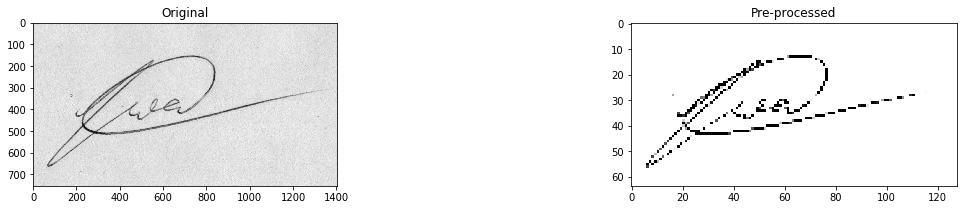

In [41]:
inp_image = './test/a2.png'


pre_processed = morph(inp_image)


fig, ax = plt.subplots(1, 2, figsize=(20, 3))

ax[0].imshow(cv2.imread(inp_image))
ax[1].imshow(cv2.cvtColor(pre_processed, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[1].set_title('Pre-processed')
plt.show()
plt.close()

#print(cv2.__version__)

### Pre-process the entire dataset

In [29]:

x = []
y = []
mapping = []

for i in range(len(unique_custs)):
    c = unique_custs[i]
    done = False
    cntr = 2
    while not done:
        if os.path.exists('/home/ec2-user/SageMaker/data/cedar/org/original_{}_{}.png'.format(c, cntr)):
            x.append(np.array([
                        morph('/home/ec2-user/SageMaker/data/cedar/org/original_{}_{}.png'.format(c, 1)),
                        morph('/home/ec2-user/SageMaker/data/cedar/org/original_{}_{}.png'.format(c, cntr))
                     ]))
            y.append(1)
            mapping.append('original_{}_{} => original_{}_{} => 1'.format(c, 1, c, cntr))
            cntr += 1
        else:
            done = True
            
    done = False
    cntr = 1
    while not done:
        if os.path.exists('/home/ec2-user/SageMaker/data/cedar/forg/forgeries_{}_{}.png'.format(c, cntr)):
            x.append(np.array([
                        morph('/home/ec2-user/SageMaker/data/cedar/org/original_{}_{}.png'.format(c, 1)),
                        morph('/home/ec2-user/SageMaker/data/cedar/forg/forgeries_{}_{}.png'.format(c, cntr))
                     ]))
            y.append(0)
            mapping.append('forgeries_{}_{} => forgeries_{}_{} => 0'.format(c, 1, c, cntr))
            cntr += 1
        else:
            done = True
            
    print("Completed: {:.2%}".format(i/len(unique_custs)), end='\r', flush=True)
    
x = np.array(x)
y = np.array(y)


In [30]:
x.shape

(2585, 2, 64, 128)

In [31]:
y.shape, np.mean(y)

((2585,), 0.48936170212765956)

In [32]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=23)

print(x_train.shape, x_valid.shape)
print(y_train.shape, y_valid.shape)
print(np.mean(y_train), np.mean(y_valid))

(1938, 2, 64, 128) (647, 2, 64, 128)
(1938,) (647,)
0.49277605779153766 0.47913446676970634


### Save the Input dataset as pickle file

In [42]:
pklfile = '../data/model_train/model_data_pre_processed.pkl'
with open(pklfile,'wb') as f:
    pickle.dump({
        'x_train': x_train,
        'x_valid': x_valid,
        'y_train': y_train,
        'y_valid': y_valid
    }, f)


### Copy to S3 bucket for Training

In [43]:
!aws s3 cp {pklfile} s3://sagemaker-chakra1/siamese/model_train1/

upload: ../data/model_train/model_data_pre_processed.pkl to s3://sagemaker-chakra1/siamese/model_train1/model_data_pre_processed.pkl
